##   Signal to Noise and Uniformity of Oil filled Sphere in 32 Channel Head Coil

In [1]:
from __future__ import division, print_function

%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mriqa.phantoms import phantom_mask_2d, find_phantom, OILSPHERE
from mriqa.dcmio import fetch_series, seq_name, approx_slice_orientation, approx_phase_orientation, rx_coil_name
from mriqa.tools import mean_im, diff_im, snr_im, snr, uniformity_ipem80, show_mosaic

#### Fetch and Analyse Images

In [4]:
# Study details
patid = 'PQA20130815RHD'
stuid = '1'

# Build results into a dataframe starting with the series numbers
orientations = {
    # raw, psn
    'Axial': {'SeriesRaw':  [8], 'SeriesNorm': [9]},
    'Sag':   {'SeriesRaw': [10], 'SeriesNorm': [11]},
    'Cor':   {'SeriesRaw': [12], 'SeriesNorm': [13]}
}
df = pd.DataFrame(orientations).T

# Fetch Images
df['ObjsRaw']         = [fetch_series(patid, stuid, sernos, 'CRIC') for sernos in df.SeriesRaw]
df['ObjsNorm']        = [fetch_series(patid, stuid, sernos, 'CRIC') for sernos in df.SeriesNorm]

# SNR
df['SNRRaw']          = [snr(*dobjs[:2]) for dobjs in df['ObjsNorm']]
df['SNRNorm']         = [snr(*dobjs[:2]) for dobjs in df['ObjsRaw']]

# Profiles and Uniformity
(   df['XProfileRaw'],
    df['XUniformityRaw'],
    df['YProfileRaw'],
    df['YUniformityRaw']
) = zip(*[uniformity_ipem80(*dobjs[:2]) for dobjs in df['ObjsRaw']])

(   df['XProfileNorm'],
    df['XUniformityNorm'],
    df['YProfileNorm'],
    df['YUniformityNorm']
) = zip(*[uniformity_ipem80(*dobjs[:2]) for dobjs in df['ObjsNorm']])

# Check Series
df['ProtocolRaw']  = [dobjs[0].ProtocolName for dobjs in df['ObjsRaw']]
df['SequenceRaw']  = [seq_name(dobjs[0]) for dobjs in df['ObjsRaw']]
df['OrientRaw']    = [approx_slice_orientation(dobjs[0]) + '/' + approx_phase_orientation(dobjs[0]) for dobjs in df['ObjsRaw']]
df['CoilRaw']      = [rx_coil_name(dobjs[0]) for dobjs in df['ObjsRaw']]

df['ProtocolNorm'] = [dobjs[0].ProtocolName for dobjs in df['ObjsNorm']]
df['SequenceNorm'] = [seq_name(dobjs[0]) for dobjs in df['ObjsNorm']]
df['OrientNorm']   = [approx_slice_orientation(dobjs[0]) + '/' + approx_phase_orientation(dobjs[0]) for dobjs in df['ObjsNorm']]
df['CoilNorm']     = [rx_coil_name(dobjs[0]) for dobjs in df['ObjsNorm']]

print('Raw Images')
display(df[['SeriesRaw',  'ProtocolRaw',  'SequenceRaw',  'OrientRaw', 'CoilRaw']])
print('Intensity Normalised Images')
display(df[['SeriesNorm', 'ProtocolNorm', 'SequenceNorm', 'OrientNorm', 'CoilNorm']])

Raw Images


SeriesRaw                         ProtocolRaw SequenceRaw    OrientRaw  \
Axial       [8]  SE_AXIAL_RL_SNR_UNIF_32CH_PSN_NORM      *se2d1     Axial/RL   
Cor        [12]    SE_COR_RL_SNR_UNIF_32CH_PSN_NORM      *se2d1   Coronal/RL   
Sag        [10]    SE_SAG_AP_SNR_UNIF_32CH_PSN_NORM      *se2d1  Sagittal/AP   

       CoilRaw  
Axial  HEA;HEP  
Cor    HEA;HEP  
Sag    HEA;HEP

Intensity Normalised Images


SeriesNorm                        ProtocolNorm SequenceNorm  \
Axial        [9]  SE_AXIAL_RL_SNR_UNIF_32CH_PSN_NORM       *se2d1   
Cor         [13]    SE_COR_RL_SNR_UNIF_32CH_PSN_NORM       *se2d1   
Sag         [11]    SE_SAG_AP_SNR_UNIF_32CH_PSN_NORM       *se2d1   

        OrientNorm CoilNorm  
Axial     Axial/RL  HEA;HEP  
Cor     Coronal/RL  HEA;HEP  
Sag    Sagittal/AP  HEA;HEP

#### Signal to Noise Ratio

To get the SNR ratio we subtract the images in pairs to get the Noise and take the mean to get the Signal. Notice that the second pair of images with PreScan normalise is much flatter than the unnormalised one; the head coil is quite surface biased.

The SNR is the average over an ROI encompassing most of the phantom.

In [5]:
pd.options.display.float_format = '{:10,.0f}'.format
df[['SNRRaw', 'SNRNorm']]

SNRRaw    SNRNorm
Axial        392        371
Cor          368        371
Sag          369        331

#### IPEM Report 80 Fractional Uniformity Analysis

We look at a (thick) profile through the centre of the phantom and determine the length of the longest run that is within 10% of the modal value. The centre of the phantom is determined using a centroid method. Note that this is over the relatively small field of view of this phantom.

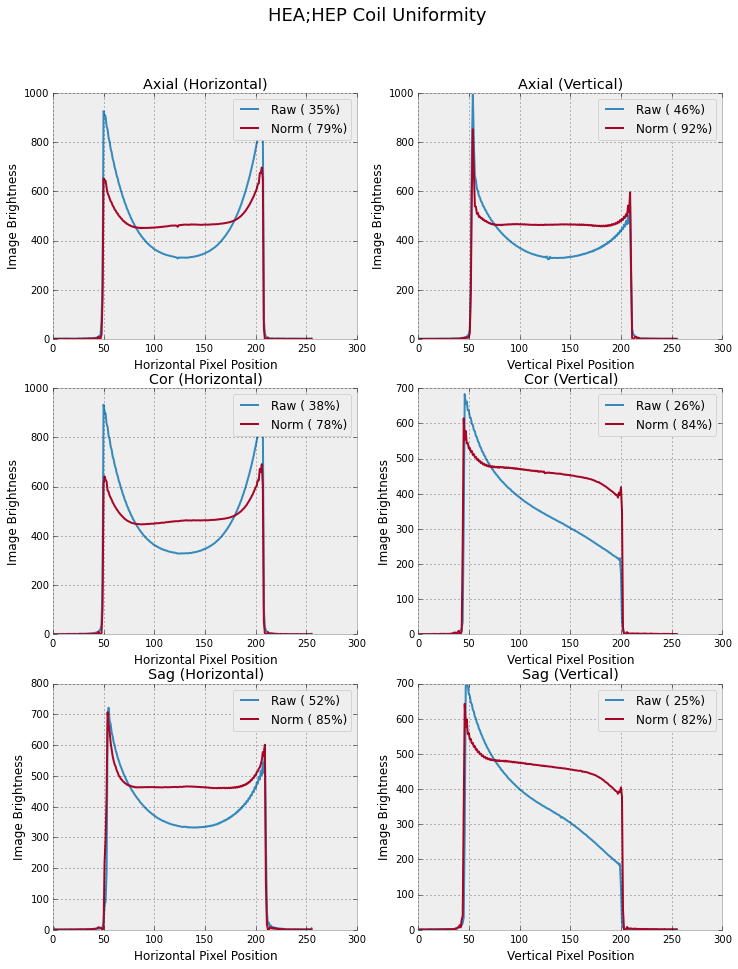

XUniformityRaw  YUniformityRaw  XUniformityNorm  YUniformityNorm
Axial             35%             46%              79%              92%
Cor               38%             26%              78%              84%
Sag               52%             25%              85%              82%

In [6]:
plt.style.use('bmh')
fig, axs = plt.subplots(len(df), 2, figsize=(12, 5*len(df)))
for i, (index, _) in enumerate(df.iterrows()):
    axs[i, 0].plot(df['XProfileRaw'][index], label='Raw (%3.0f%%)' % df['XUniformityRaw'][index])
    axs[i, 0].hold(True)
    axs[i, 0].plot(df['XProfileNorm'][index], label='Norm (%3.0f%%)' % df['XUniformityNorm'][index])
    axs[i, 0].set_xlabel('Horizontal Pixel Position')
    axs[i, 0].set_ylabel('Image Brightness')
    axs[i, 0].legend()
    axs[i, 0].grid(True)
    axs[i, 0].set_title('%s (Horizontal)' % index)
    

    axs[i, 1].plot(df['YProfileRaw'][index], label='Raw (%3.0f%%)' % df['YUniformityRaw'][index])
    axs[i, 1].hold(True)
    axs[i, 1].plot(df['YProfileNorm'][index], label='Norm (%3.0f%%)' % df['YUniformityNorm'][index])
    axs[i, 1].set_xlabel('Vertical Pixel Position')
    axs[i, 1].set_ylabel('Image Brightness')
    axs[i, 1].legend()
    axs[i, 1].grid(True)
    axs[i, 1].set_title('%s (Vertical)' % index)
    
fig.suptitle('%s Coil Uniformity' % df['CoilRaw'][0], fontsize=18)
plt.show()

pd.options.display.float_format = '{:10,.0f}%'.format
display(df[['XUniformityRaw', 'YUniformityRaw', 'XUniformityNorm', 'YUniformityNorm']])